In [22]:
import pandas as pd
import get_data as gd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from os import walk
import csv
from pychadwick.chadwick import Chadwick  
#https://github.com/jldbc/pybaseball
#https://baseballsavant.mlb.com/csv-docs
from pybaseball import statcast_pitcher
import seaborn as sns
from pybaseball import statcast
import statsmodels.api as sm
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

# Runs & Wins

The goal of any baseball team is to win as many games as you can, which you do by scoring more runs than you allow. Therefore like they say in MOneyball "Runs is the currency of winning". What this means is when you want to evaluating a player you don't need to neccessarily try and figure out how much they contribute to winning percentage, rather you can focus on how they contribute to runs scored/allowed and use that as a proxy.

The goal of this section is to explore the relationship between runs and wins.

## Getting & Cleaning the Data

We will use the Lahman dataset and only look at the relationship between runs and wins for teams in the 2000's. To do this we call the Teams.csv and filter to only records with a yearID of 2000 or more.

The next thing we need to do is calculate the Win Percentage (Wins divided by Games Played). We then calculate the average runs score and allowed per game.

In [23]:
teams_df = gd.make_df("Teams") 
teams_df = teams_df[(teams_df['yearID'] >= 2000) & (teams_df['yearID'] < 2020)]
teams_df['Win Percentage'] = teams_df['W']/teams_df['G']
teams_df['Runs Per Game'] = teams_df['R']/teams_df['G']
teams_df['Runs Allowed Per Game'] = teams_df['RA']/teams_df['G'] 

## Looking at the Data

We graph a simple scatter plot of runs score and runs allowed vs win percentage, this gives us an idea of the correlation between each of these variable and win percentage.

As you would expect runs are positive correlated and runs allowed are negatively correlated. But does one matter more than the other?

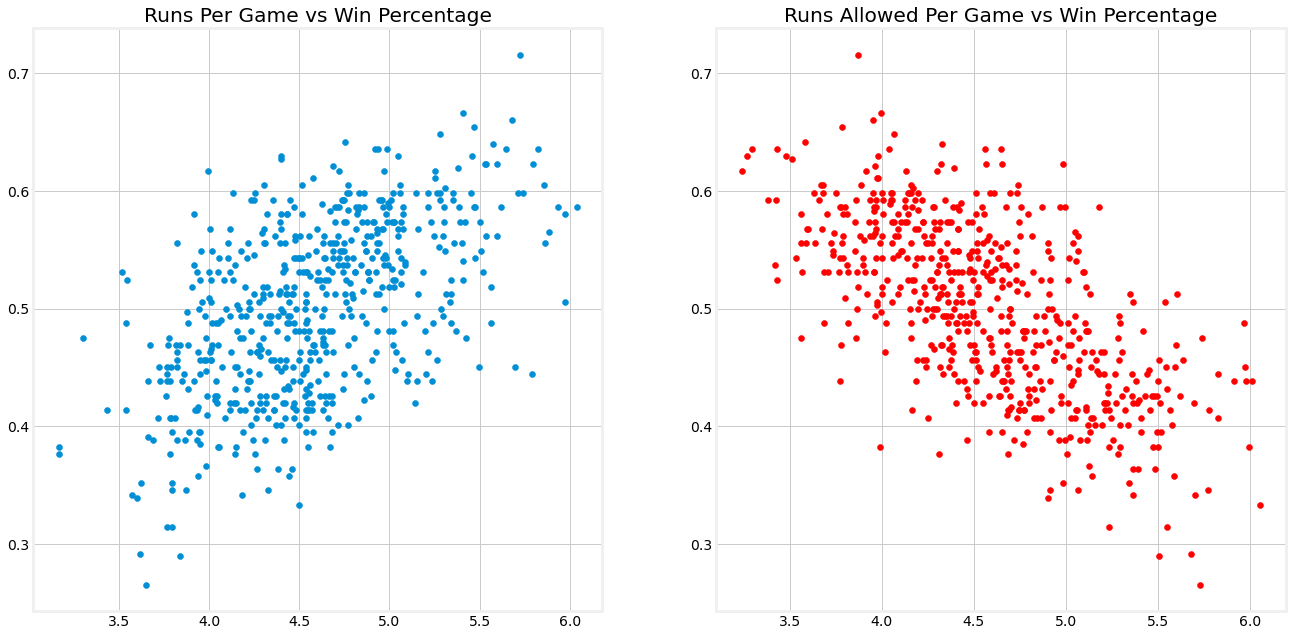

In [24]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,10))

gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax1.scatter(teams_df['Runs Per Game'], teams_df['Win Percentage'])
ax1.set_title('Runs Per Game vs Win Percentage')

fig.patch.set_facecolor('white')
ax2.set_facecolor('white')
ax2.scatter(teams_df['Runs Allowed Per Game'], teams_df['Win Percentage'], color='red')
ax2.set_title('Runs Allowed Per Game vs Win Percentage')
plt.show()

## First Method: OLS

The first method we use to look at the reltionship is running and Oridarny Least Squares (OLS). This model is simple and the easiest to understand. It will find the relationship between our independent variables (Runs and Runs Allowed) and dependent variable (Win Percentage) which gets the square or the errors as low as possible.

When you look at the coefficients you can read it as a one unit increase in that variable will result in that much of a change in the win percentage. So for example, an increae of 1 run per game for a team should result in an increase in their win percentage of 9.6% while an increase of 1 run allowed per game should decrease the win percentage by 10.2%. The confidence intervals give us the range of the coefficients we could reasonable expect.

A disadvantage of an OLS is it doesn't know that a win rate can't be higher than one or lower than zero. This will be something we tackle with the next method.

In [25]:
teams_df['Intercept'] = 1
y = teams_df['Win Percentage']
X = teams_df[['Runs Per Game','Runs Allowed Per Game','Intercept']]
full_model = sm.OLS(y, X, hasconst=True).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Win Percentage   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     2255.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):          5.46e-279
Time:                        14:53:56   Log-Likelihood:                 1366.1
No. Observations:                 600   AIC:                            -2726.
Df Residuals:                     597   BIC:                            -2713.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Runs Per Game             0.09

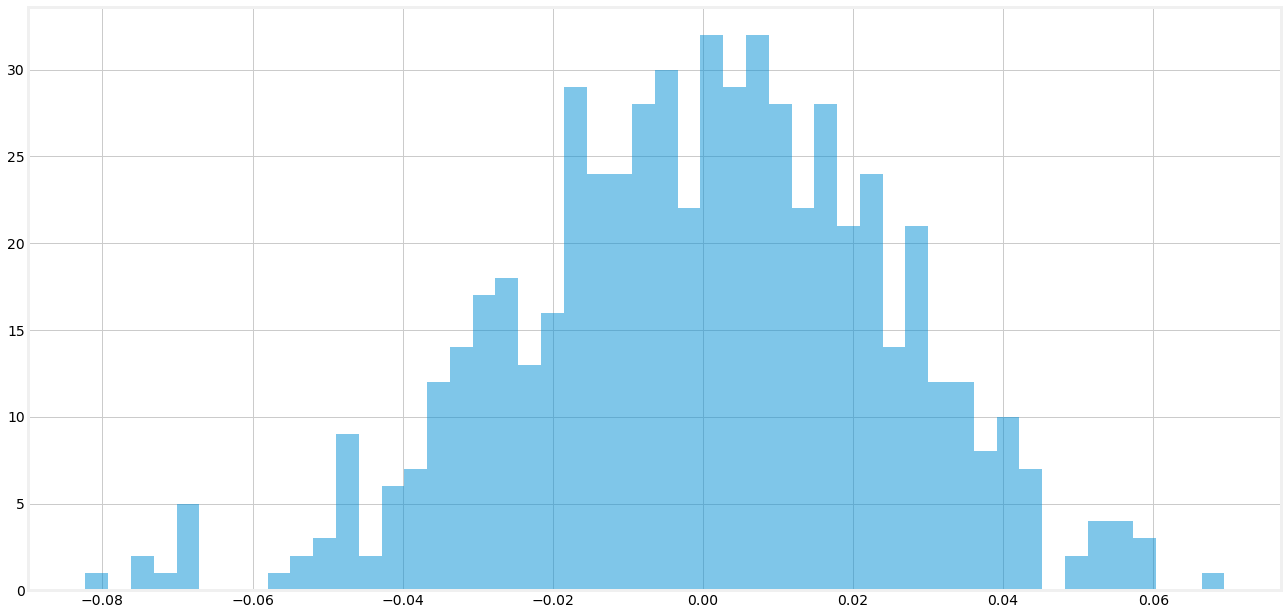

In [26]:
prediction = full_model.predict(teams_df[['Runs Per Game','Runs Allowed Per Game','Intercept']])
teams_df['OLS Win Prediction'] = teams_df['G'] * prediction
teams_df['OLS Residual'] = prediction - teams_df['Win Percentage']
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize= (20,10))
fig.patch.set_facecolor('white')
#ax.scatter(prediction, res)
ax.hist(teams_df['OLS Residual'], alpha = 0.5, bins=50)
ax.set_facecolor('white')
#ax.set_xlim(0,100)
#ax.set_ylim(-20,20)

In [27]:
teams_df[['OLS Residual']].describe()

,OLS Residual
count,600.00
mean,-0.00
std,0.02
min,-0.08
25%,-0.02
50%,0.00
75%,0.02
max,0.07


## Second Method: Logit Regression

A logit regression solves for the issue of win percentage being constrainted between 0 to 1, it does this with a minor sacrfice for understandablility (at least for me).

A good way to think of a logit regression, is it performs a transformation of the data to model the relationship between our independent variables and the odd's ratio of our dependent. The exact transformation is outlined below:

logit(p) = log(p/(1-p)) = B0 + B1*(Runs Scored Per Game) + B2*(Runs Scored Per Game) 

So when we get the regression output, we can take the exponent of the coefficients and find their relationship to the odd's ratio. A coefficient of greater than one means it positively increases the chances and below one means it decreases the chances.

In [28]:
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.674688
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         Win Percentage   No. Observations:                  600
Model:                          Logit   Df Residuals:                      597
Method:                           MLE   Df Model:                            2
Date:                Mon, 05 Apr 2021   Pseudo R-squ.:                 0.02663
Time:                        14:53:56   Log-Likelihood:                -404.81
converged:                       True   LL-Null:                       -415.89
Covariance Type:            nonrobust   LLR p-value:                 1.549e-05
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Runs Per Game             0.3924      0.164      2.387      0.017       0.070       0.

Runs per game has a coefficient of 1.48, means an extra run per game increases the odds of winning by close to 50%. While getting an extra run scored against you decreases your odds of winning by almost 40%.

In [29]:
np.exp(logit_model.params)

Runs Per Game           1.48
Runs Allowed Per Game   0.66
Intercept               1.11
dtype: float64

## Residuals 

Like before the fitted result shows no relationship with the residuals which is a good thing, as well there is a minor decrease in the SSR which indicates this model is a tiny bit better.

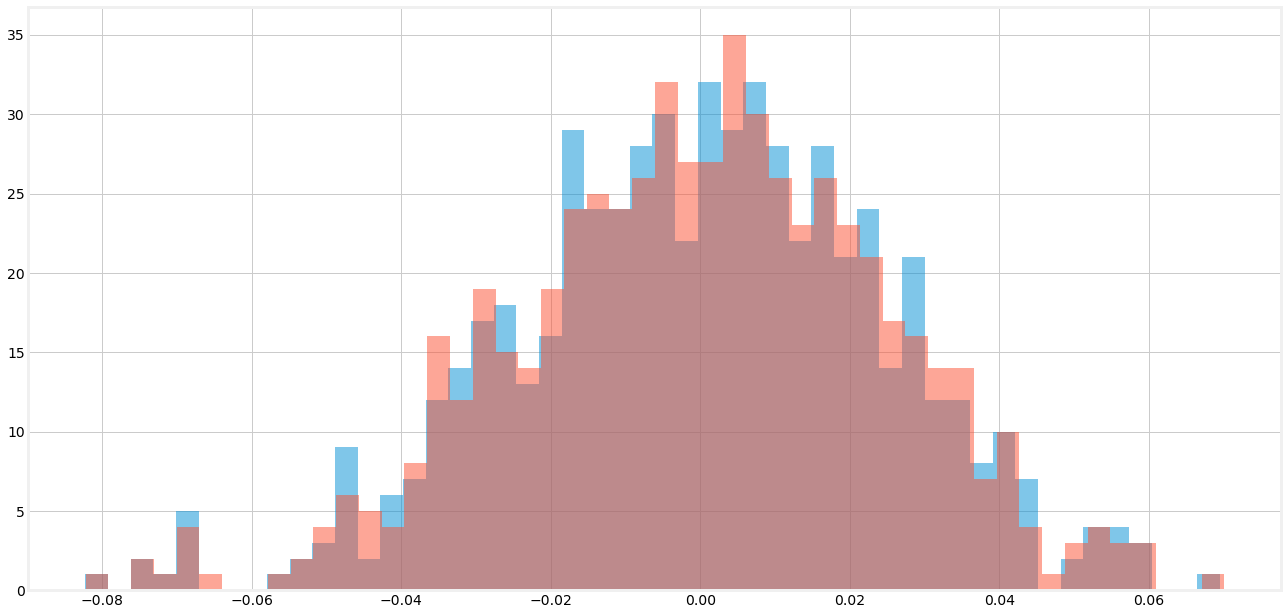

In [30]:
prediction = logit_model.predict(X)
#res = prediction - teams_df['Win Percentage']
teams_df['Logit Win Prediction'] = teams_df['G'] * prediction
teams_df['Logit Residual'] = prediction - teams_df['Win Percentage']
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize= (20,10))
fig.patch.set_facecolor('white')
#ax.scatter(prediction, res)
ax.hist(teams_df['OLS Residual'], alpha = 0.5, bins=50)
ax.hist(teams_df['Logit Residual'], alpha = 0.5, bins=50)
ax.set_facecolor('white')
#ax.set_xlim(0,100)
#ax.set_ylim(-20,20)

In [31]:
teams_df[['OLS Residual', 'Logit Residual']].describe()

,OLS Residual,Logit Residual
count,600.00,600.00
mean,-0.00,0.00
std,0.02,0.02
min,-0.08,-0.08
25%,-0.02,-0.02
50%,0.00,0.00
75%,0.02,0.02
max,0.07,0.07


In [32]:
teams_df[['OLS Residual', 'Logit Residual']].apply(lambda x: x**2).sum()

OLS Residual     0.37
Logit Residual   0.37
dtype: float64

# Pythrongan Formula for Winning Percentage

Bill James developed an formula for estimating winning percentage which was R^2 / (R^2+RA^2)

In [33]:
prediction = teams_df['R']**2/(teams_df['R']**2 + teams_df['RA']**2)

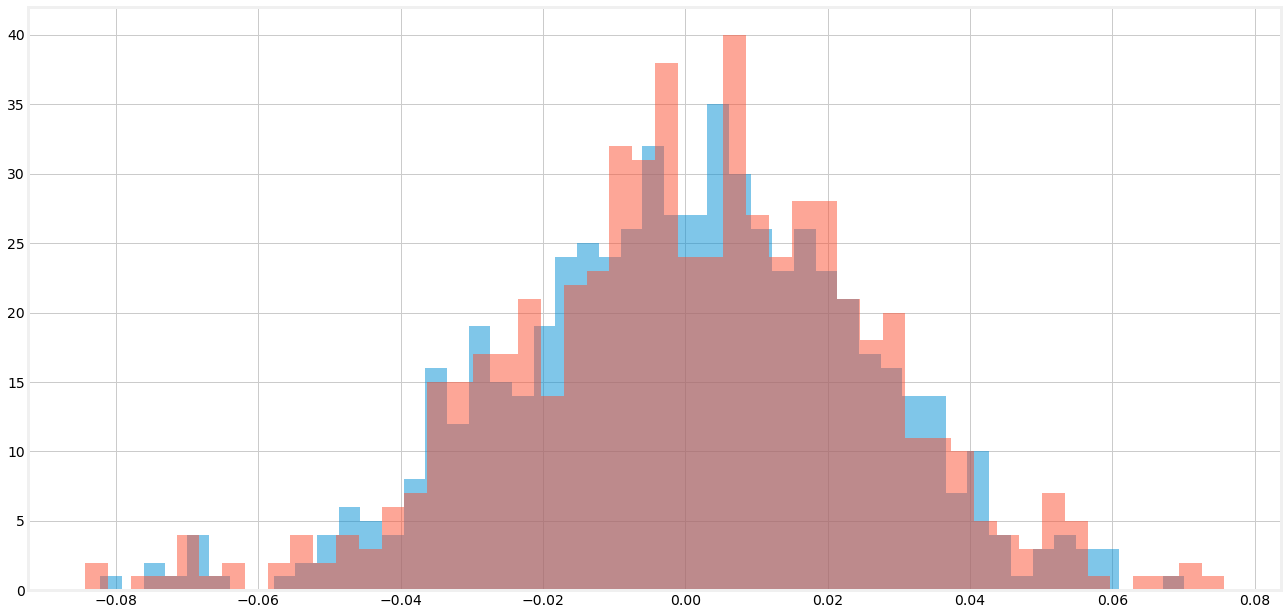

In [34]:
prediction = teams_df['R']**2/(teams_df['R']**2 + teams_df['RA']**2)
teams_df['Pythagorean Win Prediction'] = teams_df['G'] * prediction
teams_df['Pythagorean Residual'] = prediction - teams_df['Win Percentage']
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize= (20,10))
fig.patch.set_facecolor('white')
#ax.scatter(prediction, res)
ax.hist(teams_df['Logit Residual'], alpha = 0.5, bins=50, label='Logit Residuals')
ax.hist(teams_df['Pythagorean Residual'], alpha = 0.5, bins=50,  label='Pythagorean Residuals')
ax.set_facecolor('white')
#ax.set_xlim(0,100)
#ax.set_ylim(-20,20)

In [35]:
teams_df[['OLS Residual', 'Logit Residual', 'Pythagorean Residual']].describe()

,OLS Residual,Logit Residual,Pythagorean Residual
count,600.00,600.00,600.00
mean,-0.00,0.00,0.00
std,0.02,0.02,0.03
min,-0.08,-0.08,-0.08
25%,-0.02,-0.02,-0.02
50%,0.00,0.00,0.00
75%,0.02,0.02,0.02
max,0.07,0.07,0.08


In [36]:
teams_df[['OLS Residual', 'Logit Residual', 'Pythagorean Residual']].apply(lambda x: x**2).sum()

OLS Residual           0.37
Logit Residual         0.37
Pythagorean Residual   0.39
dtype: float64

In [37]:
y = np.log(teams_df['W']/teams_df['L'])
X = np.log(teams_df['R']/teams_df['RA'])
py_model = sm.OLS(y, X, hasconst=False).fit()
print(py_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.880
Model:                            OLS   Adj. R-squared (uncentered):              0.880
Method:                 Least Squares   F-statistic:                              4396.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):                   4.58e-278
Time:                        14:53:59   Log-Likelihood:                          514.93
No. Observations:                 600   AIC:                                     -1028.
Df Residuals:                     599   BIC:                                     -1023.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

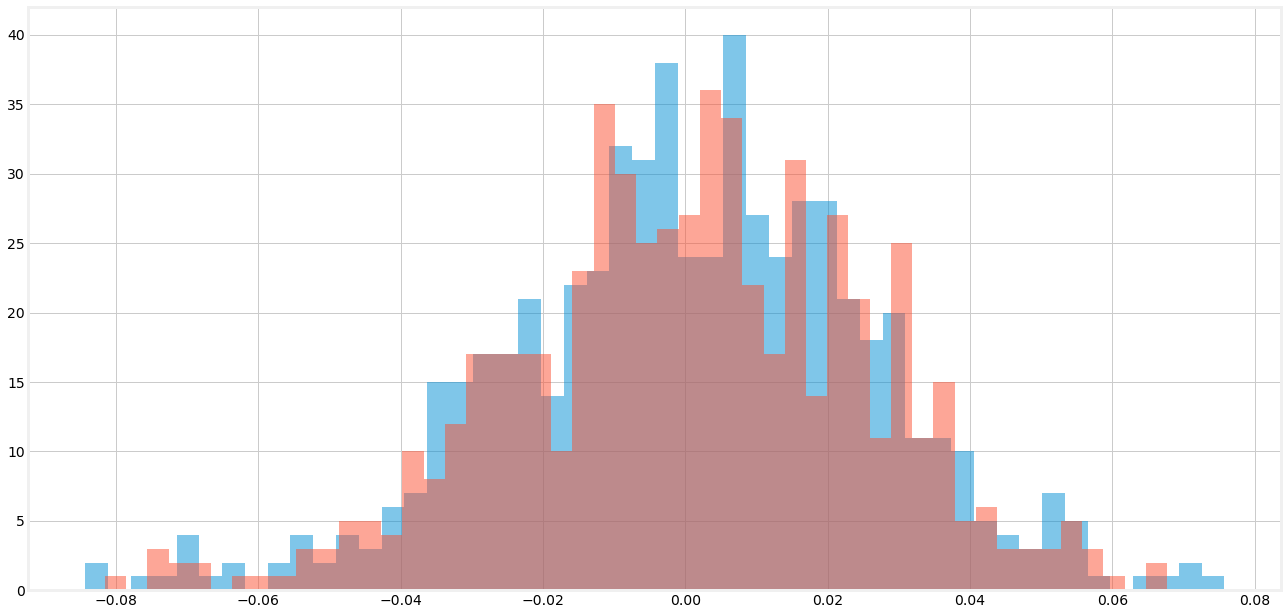

In [38]:
exponent = 1.8508
prediction = teams_df['R']**exponent/(teams_df['R']**exponent + teams_df['RA']**exponent)
teams_df['Updated Pythagorean Win Prediction'] = teams_df['G'] * prediction
teams_df['Updated Pythagorean Residual'] = prediction - teams_df['Win Percentage']
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize= (20,10))
fig.patch.set_facecolor('white')
#ax.scatter(prediction, res)
ax.hist(teams_df['Pythagorean Residual'], alpha = 0.5, bins=50,  label='Pythagorean Residuals')
ax.hist(teams_df['Updated Pythagorean Residual'], alpha = 0.5, bins=50,  label='Pythagorean Residuals')
ax.set_facecolor('white')
#ax.set_xlim(0,100)
#ax.set_ylim(-20,20)

In [39]:
teams_df[['OLS Residual', 'Logit Residual', 'Pythagorean Residual','Updated Pythagorean Residual']].describe()

,OLS Residual,Logit Residual,Pythagorean Residual,Updated Pythagorean Residual
count,600.00,600.00,600.00,600.00
mean,-0.00,0.00,0.00,0.00
std,0.02,0.02,0.03,0.03
min,-0.08,-0.08,-0.08,-0.08
25%,-0.02,-0.02,-0.02,-0.01
50%,0.00,0.00,0.00,0.00
75%,0.02,0.02,0.02,0.02
max,0.07,0.07,0.08,0.07


In [40]:
teams_df[['OLS Residual', 
          'Logit Residual', 
          'Pythagorean Residual',
          'Updated Pythagorean Residual']].apply(lambda x: x**2).sum()

OLS Residual                   0.37
Logit Residual                 0.37
Pythagorean Residual           0.39
Updated Pythagorean Residual   0.38
dtype: float64

In [41]:
teams_df.sort_values(by='Pythagorean Residual')[['yearID', 
                                                 'teamID', 
                                                 'W', 
                                                 'R',
                                                 'RA',
                                                 'OLS Win Prediction', 
                                                 'Logit Win Prediction', 
                                                 'Pythagorean Win Prediction',
                                                 'Updated Pythagorean Win Prediction']]

,yearID,teamID,W,R,RA,OLS Win Prediction,Logit Win Prediction,Pythagorean Win Prediction,Updated Pythagorean Win Prediction
2857,2017,SDN,71,604,816,60.12,60.24,57.34,59.01
2832,2016,TEX,95,765,757,81.67,81.68,81.85,81.79
2475,2005,ARI,77,696,856,64.91,64.86,64.47,65.68
2888,2018,SEA,89,677,711,77.87,77.81,77.03,77.33
2463,2004,NYA,101,897,808,89.21,89.31,89.43,88.81
...,...,...,...,...,...,...,...,...,...
2803,2015,TOR,93,891,670,102.71,102.53,103.48,101.89
2852,2017,NYA,91,858,660,100.54,100.47,101.78,100.29
2878,2018,LAN,92,804,610,100.96,100.89,103.45,101.88
2512,2006,CLE,78,870,782,89.25,89.36,89.61,88.97


In [ ]:
#https://en.wikipedia.org/wiki/2014_Oakland_Athletics_season

In [ ]:
games_df = gd.make_gamelog_df()